In [195]:
# Code imports
from lib.opt_types import *
from lib.utils import *
import math
import sys
sys.path.append("/lib/inpainting.py")

# Image inpainting with proximal methods - 30 points

Image in-painting consists of reconstructing the missing parts of an image from a given incomplete image.

By exploiting some prior knowledge on the image, it is possible to in-paint images that have a large portion of their pixels missing. In this part of the homework, we are going to study different methods to achieve this goal.

We consider a subsampled image $\mathbf{b} = \mathbf{P}_{\Omega} \mathbf{x}$, where $\mathbf{P}_{\Omega} \in \mathbb{R}^{n \times p}$ is an operator that selects only few, $n \ll p := m^2$, pixels from the vectorized image $\mathbf{x} \in \mathbb{R}^p$. Our goal is to reconstruct the original image $\mathbf{x}$.

### Prior knowledge

Image inpainting is impossible without having some prior knowledge on the structure of the true image $\mathbf{x}$. 

We will explore and compare the following prior assumptions we can make on the true image: 
>  **Assumption**: There exists a orthonormal basis $\mathbf{W} \in \mathbb{R}^{p\times p}$ such that $\mathbf{x}$ can be sparsely represented in that basis, i.e, $\mathbf{W} \mathbf{x}$ is a vector with few non-zero coefficients. Said more formally, this assumption states that there exists $\mathbf{\alpha} \in \mathbb{R}^p$ with small $\ell_1$ norm such that $\mathbf{x} = \mathbf{W}^\top\alpha$. We assume that this basis is known and corresponds to the _wavelet basis_. Under this assumption, the reconstruction problem corresponds to solving the following optimization problem:
    $$
    \min_{\mathbf{\alpha} \in \mathbb{R}^{p}} \underbrace{ \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2}_{f_{\ell_1}(\mathbf{\alpha})} + \underbrace{\lambda_{\ell_1} \|\mathbf{\alpha}\|_1}_{g_{\ell_1}(\mathbf{\alpha})},
    $$
    where $\lambda_{\ell_1}$ is a coefficient we will need to choose.



# PART 1: Optimizing with an $\ell_1$ norm regularization

The optimization problem we are looking to solve have an objective function of the form:
$$
	 f(\mathbf{x}) + g(\mathbf{x}).
$$

These types of objectives are referred to as _composite objectives_ where one term, $f$, is smooth and differentiable and the other term $g$ is non-differentiable.

---

## Code structure:

Recall that we have been working with the `Function` type so far. We will augment this type to represent functions that are not differentiable:

- Given a `Function` `g` you can obtain a subgradient at a point `x` by calling `g.subgrad(x)`.

Moreover, since we are dealing with _composite_ problems with a an objective function that can be written `f + lambda*g`, we define the `CompositeFunction` type defined as
```python
@dataclass
class CompositeFunction:
    f: Function
    g: Function
```

The iterative schemes you will implement will receive a composite function that they can unpack as follows:

```python
def state_update(composite_function, state):
    f, g = composite_function

```

#### Question 1: (5 point)

A first approach to solve a non-smooth optimization problem can be to turn to subgradients. Review slide 42-44 of Lecture 6, and implement `SubG` with $\alpha_k = \frac{0.1}{\sqrt{k}}$.

In [196]:
@dataclass
class SubG_state(OptState):
    x_k: Vector
    #FILL
    alpha_k: float
    k : int

In [197]:
def SubG_update(composite_function, state):
    f, g, = composite_function
    #FILL
    x_next = state.x_k - state.alpha_k * np.array(f.grad(state.x_k) + g.subgrad(state.x_k))
    k_next = state.k + 1
    alpha_next = 0.1 / math.sqrt(state.k)
    return SubG_state(x_next, alpha_next, k_next)

def SubG_initialize(composite_function, x_zero):
    alpha_zero = 0.1
    k_zero = 1
    return SubG_state(x_zero, alpha_zero, k_zero)

In [198]:
SubG = OptAlgorithm(name="SubG", init_state=SubG_initialize, state_update=SubG_update)

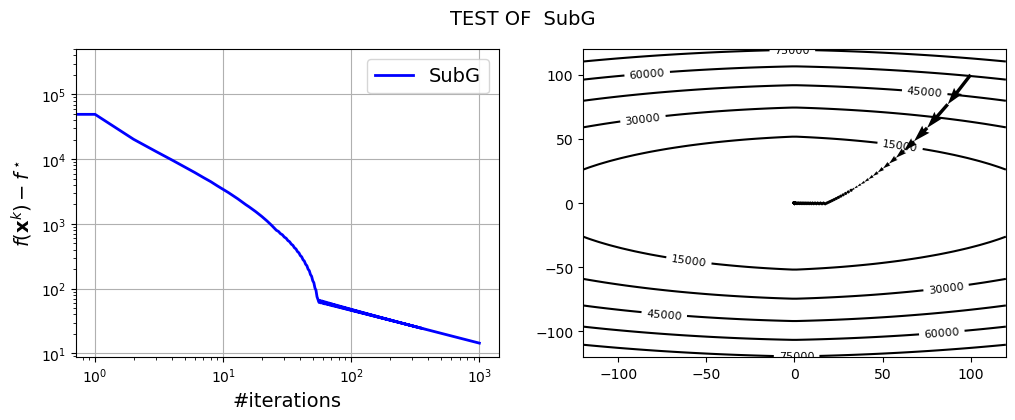

In [199]:
test_composite(SubG)


---

Another, more efficient approach, as we saw in Lecture 7, is to minimize such a function by using proximal gradient algorithms, provided that $g$ is _proximable_ (i.e., its proximal operator is efficient to evaluate). We recall the proximal operator of $g$ as the solution to the following convex problem:
$$
\mathrm{prox}_g(\mathbf{z}) := \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^d}\{ g(\mathbf{y}) + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\}.
$$

#### Question 2 (2 points)

Given $g_{\ell_1}: \mathbb{R}^p \rightarrow \mathbb{R}, \; g_{\ell_1}(\mathbf{x}) :=  \|\mathbf{x}\|_1$,  show that its proximal function can be written as
    $$
    \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}|-\gamma,0) \circ \mathrm{sign}(\mathbf{z}), \; \text{for any }\mathbf{z} \in \mathbb{R}^p,\; \gamma \in \mathbb{R}_+
    $$
			where the operators $\max$, $\mathrm{sign}$ and $\lvert \cdot \lvert$ are applied coordinate-wise to the vector $\mathbf{z}$ and $\circ$ stands for $(\mathbf{x} \circ \mathbf{y})_i = x_i y_i$. Such a regularizer imposes sparsity on the solutions.


Since the objective function is separable, we can minimize each coordinate $x_i$ independently:
$$
\min_{x_i \in \mathbb{R}} \left\{ \frac{1}{2} (x_i - z_i)^2 + \gamma |x_i| \right\}.
$$

For each coordinate $i$, we solve:
$$
\min_{x_i \in \mathbb{R}} \left\{ \frac{1}{2} (x_i - z_i)^2 + \gamma |x_i| \right\}.
$$
Consider three cases:

1. **If $x_i > 0$:** Then $|x_i| = x_i$, and the objective becomes $\frac{1}{2} (x_i - z_i)^2 + \gamma x_i$.
   Setting the derivative to zero gives $x_i = z_i - \gamma$, valid if $z_i > \gamma$. Otherwise, $x_i = 0$.

2. **If $x_i < 0$:** Then $|x_i| = -x_i$, and the objective becomes $\frac{1}{2} (x_i - z_i)^2 + \gamma (-x_i)$.
   Setting the derivative to zero gives $x_i = z_i + \gamma$, valid if $z_i < -\gamma$. Otherwise, $x_i = 0$.

3. **If $x_i = 0$:** Optimality requires $-\gamma \leq z_i \leq \gamma$.

Combining these cases, we have
$$
x_i = \begin{cases} 
      z_i - \gamma & \text{if } z_i > \gamma, \\
      0 & \text{if } |z_i| \leq \gamma, \\
      z_i + \gamma & \text{if } z_i < -\gamma.
   \end{cases}
$$
This can be compactly expressed as:
$$
x_i = \max(|z_i| - \gamma, 0) \cdot \mathrm{sign}(z_i).
$$

### Step 4: Vector Form
Applying this element-wise to each component \(z_i\), we obtain the vector form:
$$
\mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}| - \gamma, 0) \circ \mathrm{sign}(\mathbf{z}),
$$
where $\max$, $|\cdot|$, and $\mathrm{sign}$ are applied coordinate-wise, and $\circ$ denotes the element-wise product.

#### Question 3 (1 point)
 Fill in the function `l1_prox` with the proximal operator of $g_{\ell_1}$.

In [200]:
def l1_prox(gamma, z):
    #FILL
    return np.maximum(np.abs(z) - gamma, 0) * np.sign(z)

#### Question 4 (4 points)

From here on, in order to speed-up the convergence of the optimization, let's assume that the function $f$ has been made to be $\mu$-strongly convex by the addition of an $\ell_2$ regularization term to the function $f$, while the $\ell_1$ term, $g$, has remained unchanged. As such, we must now utilize the strong-convexity versions of the composite optimization algorithms.

Using the information in Lecture 7 slide 21 fill in the codes of the method ISTA$_{\mu}$.

In [201]:
@dataclass
class ISTA_state(OptState):
    x_k: Vector
    #FILL
    alpha_k : float

In [202]:
def ISTA_update(composite_function, state):
    #FILL
    f, g = composite_function
    x_next = g.prox(state.alpha_k, state.x_k - state.alpha_k * np.array(f.grad(state.x_k)))
    alpha_next = 2 / (f.lips_grad + f.strng_cvx)
    return ISTA_state(x_next, alpha_next)

def ISTA_initialize(composite_function, x_zero):
    #FILL
    f, g = composite_function
    alpha_zero = 2 / (f.lips_grad + f.strng_cvx)
    return ISTA_state(x_zero, alpha_zero)

In [203]:
ISTA = OptAlgorithm(name="ISTA", init_state= ISTA_initialize, state_update=ISTA_update)

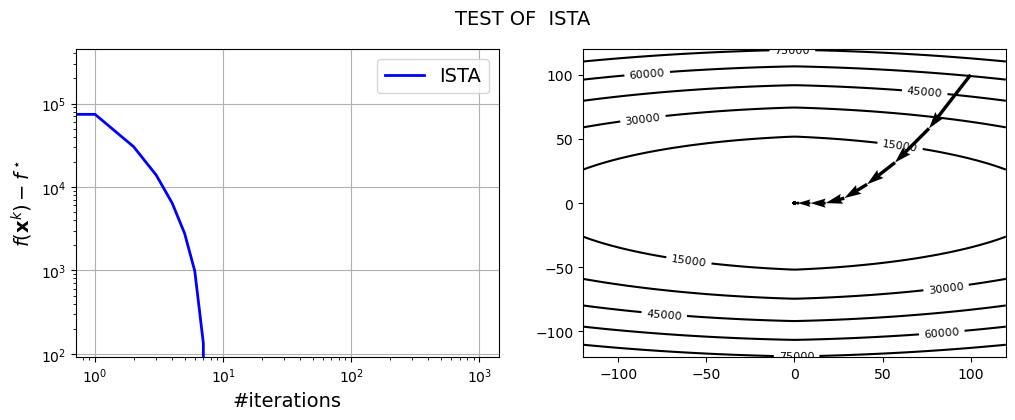

In [204]:
test_composite(ISTA)

#### Question 5  (7 points)

Using the information in Lecture 7 slide 21 fill in the codes of the method FISTA$_{\mu}$.

In [205]:
@dataclass 
class FISTA_state(OptState):
    x_k: Vector
    #FILL
    y_k : Vector
    alpha_k : float
    c_k : float


In [206]:
def FISTA_update(composite_function, state):
    #FILL
    f, g = composite_function
    x_next = g.prox(state.alpha_k, state.y_k - state.alpha_k * np.array(f.grad(state.y_k)))
    y_next = x_next + (math.sqrt(state.c_k)-1) / (math.sqrt(state.c_k)+1) * (x_next - state.x_k)
    return FISTA_state(x_next, y_next, state.alpha_k, state.c_k)

def FISTA_initialize(composite_function, x_zero):
    #FILL
    f, g = composite_function
    y_zero = x_zero
    alpha_zero = 1 / f.lips_grad
    c_zero = f.lips_grad / f.strng_cvx
    return FISTA_state(x_zero, y_zero, alpha_zero, c_zero)

In [207]:
FISTA = OptAlgorithm(name="FISTA", init_state= FISTA_initialize, state_update=FISTA_update)

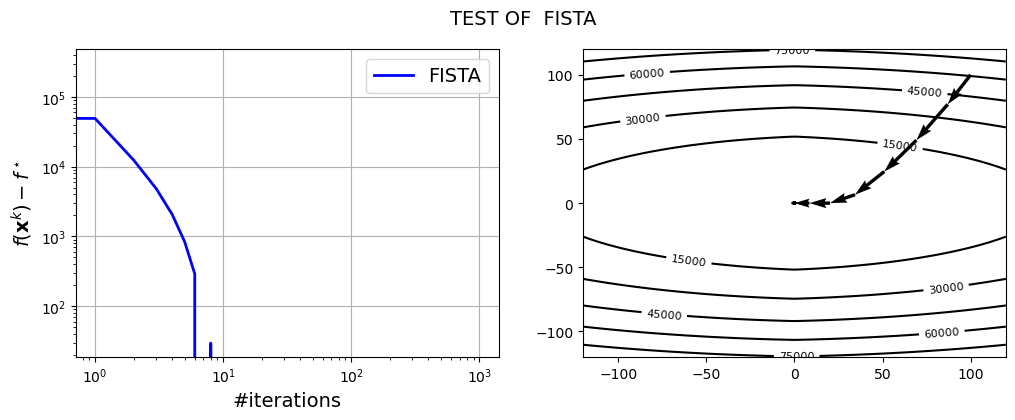

In [208]:
test_composite(FISTA)

#### Question 6  (2 points)

Compare the convergence rates of the three methods and analyze whether the observed results align with their theoretical bounds.

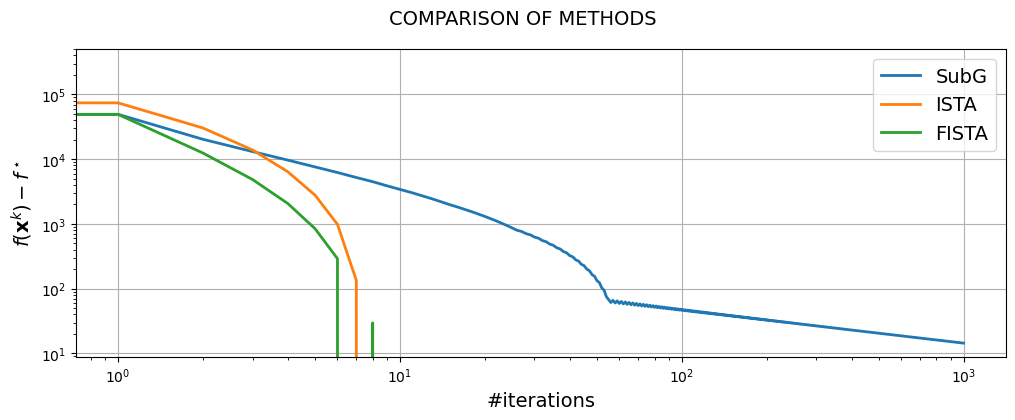

In [209]:
list_of_methods = [SubG, ISTA, FISTA]
compare_composite(list_of_methods)

1. *SubG:* 
   - Theoretical Bound: The subgradient method generally converges at a rate of $O(1/\sqrt{k})$ for non-smooth optimization, which aligns with the observed slower convergence rate in the plot.

2. *ISTA:* 
   - Theoretical Bound: ISTA typically has a convergence rate of $O(1/k)$ for convex problems, which is faster than SubG's $O(1/\sqrt{k})$. This matches the plot, where ISTA shows a steeper descent in function value initially compared to SubG.

3. *FISTA:* 
   - Theoretical Bound: FISTA is known for its accelerated convergence rate of $O(1/k^2)$, which is faster than ISTA's $O(1/k)$. This accelerated rate is confirmed in the plot, where FISTA quickly outperforms both ISTA and SubG.

# Part 2: Application


We have now implemented multiple methods that can solve composite optimization problems. We will now apply them to an image inpainting problem.


Take a natural image, or better a picture of you, and place it in the same directory as this notebook.

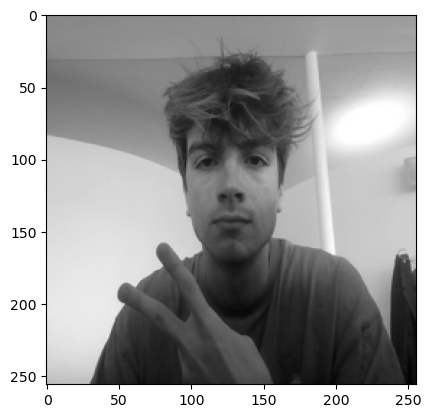

In [210]:
from lib.inpainting import *

image = load("lib/pic.jpg") #FILL IN FILE NAME

With this image in hand, let us subsample it and try to reconstruct the original.

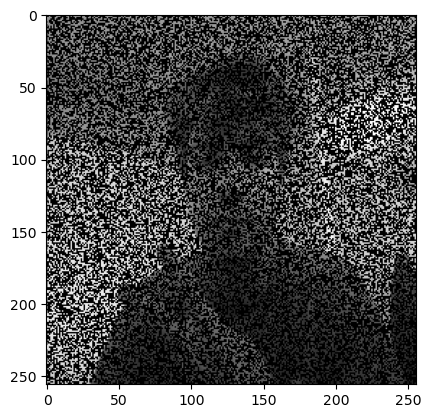

In [211]:
subsampled = show_subsampled(image)

In the following cells we will define the optimization problems we need to solve to perform the reconstruction.

- We provide you with a function `P` that acts like the matrix $\mathbf{P}_{\Omega}$. That is, given a vector `x`, it returns a subsampled vector `P(x)` that corresponds to $\mathbf{P}_{\Omega} \mathbf{x}$. We also give you `P_T` which acts like $\mathbf{P}^\top$.
- We provide you with a function `W` and `W_T` that act like the matrix $\mathbf{W}$ and $\mathbf{W^\top}$ respectively. That is, for a vector `x`, `W(x)` and `W_T(x)` return $\mathbf{W}\mathbf{x}$ and $\mathbf{W^\top}\mathbf{x}$ respectively.

__(a)__ (1 point) Using these provided functions, define the observed variable `b` in the cell below.

In [212]:
from lib.inpainting import P, P_T, W, W_T

x = image.reshape(-1) #flattened image

b = P(x)

__(b)__ (1 point) Now define the function `f_l1` as described earlier in the problem text.

In [213]:
mu = 1.0 # Desired strong convexity of f
def f_l1(alpha):
    #FILL
    return (np.linalg.norm(b - P(W_T(alpha))))

__(c)__ (1 point) Write the gradient of $f_{\ell_1}(\mathbf{\alpha})$.

In [214]:
def grad_f_l1(alpha):
    return (- W(P_T(b - P(W_T(alpha)))))

__(d)__ (1 points) Find the Lipschitz constant of $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha})$ analytically and fill it in the cell below. 

The Lipschitz constant for the gradient of a function that can be expressed as a composition of linear transformations can be bounded by the product of the operator norms of these transformations. Thus, we have:

$
L = \| W \| \cdot \| P^T \| \cdot \| P \| \cdot \| W^T \|
$

In [215]:
lips_grad_f_l1 = 1

We have all the necessary ingredients to define the smooth part of our composite objective:

In [216]:
f_l1 = Function(f = f_l1, grad=grad_f_l1, lips_grad = lips_grad_f_l1, strng_cvx=mu)

For the non-smooth term, we define a regularizer built around the `l1` function that re-uses the `l1_prox` function you implemented earlier:

In [217]:
l1 = Function(f = lambda x: np.sum(np.abs(x), axis=0), prox=l1_prox)

g_l1 = Regularizer(l1)

In [218]:
composite_objective = CompositeFunction(f=f_l1, g=g_l1)

With the objective defined, we provide you with a function with the following signature:
```python
solve_composite(method: OptAlgorithm, composite_objective: CompositeFunction, lmda: float, max_iterations: int) -> Vector
```

In other words, the function takes an optimization algorithm `method`, a CompositeFunction `composite_objective`, a regularization parameter `lmda` and a number of iterations `max_iterations` and returns a vector which is the last iterate given by the `method`.



In [219]:
from lib.inpainting import solve_composite

__(e)__ (5 points) Using `solve_composite` reconstruct the subsampled image. Recall that the composite problem solves for $\mathbf{\alpha}$ so you need to convert the output back to an image and visualize it.

Select a reasonable value for `lmda` or (BONUS) using the function `solve_composite` and the `PSNR` metric, find the best value for `lmda`.

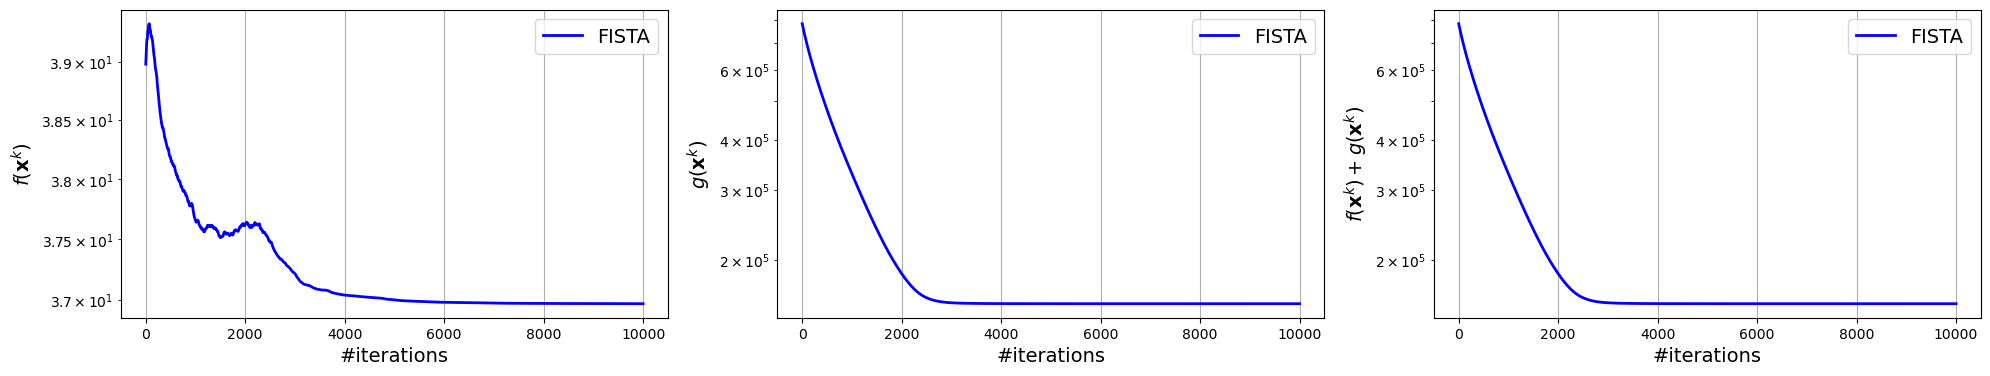

In [220]:
output = solve_composite(FISTA, composite_objective, 0.2, 10000)

In [221]:
flat_image_out = W_T(output)
image_out = flat_image_out.reshape(256, 256)

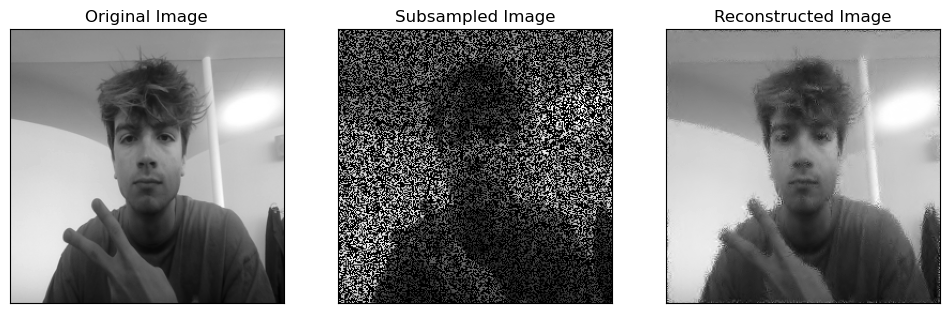

In [222]:
show(true = image, subsampled=subsampled, estimated=image_out)